In [2]:
import math, random
import matplotlib.pyplot as plt
import librosa
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import os
import pathlib
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

#### Function to read audio from .wav files

In [4]:
def read_audio(x):
    y = librosa.load(x)[0]
    return librosa.util.fix_length(y, size=11025)

#### Function to convert each audiowave into mel-spectrogram images

In [5]:
def calc_mel_spectrogram(y, sr = 22050, n_fft = 2048, hop_length = 512, n_mels=128):
    spect = librosa.feature.melspectrogram(y=y, n_fft=n_fft, sr=sr, hop_length=hop_length, n_mels = n_mels)
    return librosa.power_to_db(spect, ref=np.max)
    

#### Function to assign labels to each audio file based on patient metadata (clinical information)

In [6]:
def find_label(participant):
    return clinical_data['tb_status'][clinical_data['participant']==participant].to_list()[0]

##### Reading metadata and clinical_information file from the directory and assigning labels to each audio file

In [7]:
clinical_data = pd.read_csv("Clinical_Meta.csv")
metadata_solicited = pd.read_csv("Solicited_Meta.csv")

In [8]:
label = metadata_solicited['participant'].apply(find_label, convert_dtype=True, args=())
metadata_solicited['label'] = label
metadata_solicited['relative_path'] = 'solicited/' + metadata_solicited['filename']


/var/folders/7q/m4xnvvz54q5bmp4svjrhzn8wyyhlpq/T/ipykernel_51726/1104517988.py:1: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  label = metadata_solicited['participant'].apply(find_label, convert_dtype=True, args=())


#### Splits a Pandas dataframe into three subsets (train, val, and test) following fractional ratios provided by the user

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split

def split_stratified_into_train_val_test(df_input, stratify_colname='label',
                                         frac_train=0.6, frac_val=0.2, frac_test=0.2,
                                         random_state=1):
    if round(frac_train + frac_val + frac_test) != 1.0:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' % \
                         (frac_train, frac_val, frac_test))

    if stratify_colname not in df_input.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    X = df_input # Contains all columns.
    y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      stratify=y_temp,
                                                      test_size=relative_frac_test,
                                                      random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test

##### The metadata data file is split into 3 components in the ratio train:val:test = 6:2:2

In [10]:
df_train, df_val, df_test = split_stratified_into_train_val_test(metadata_solicited, stratify_colname="label")

##### Read all the files (train, test and val) and converting them into mel-spectrogram images

In [11]:
list_audio_train = []
for i in df_train['relative_path']:
    list_audio_train.append(read_audio(i))

In [12]:
list_audio_test = []
for i in df_test['relative_path']:
    list_audio_test.append(read_audio(i))

In [13]:
list_audio_val = []
for i in df_val['relative_path']:
    list_audio_val.append(read_audio(i))

In [14]:
mel_spectrogram_train = np.array(list(map(calc_mel_spectrogram, list_audio_train)))
mel_spectrogram_val = np.array(list(map(calc_mel_spectrogram, list_audio_val)))
mel_spectrogram_test = np.array(list(map(calc_mel_spectrogram, list_audio_test)))

In [15]:
X_train = np.expand_dims(mel_spectrogram_train, -1)
X_val = np.expand_dims(mel_spectrogram_val, -1)
X_test = np.expand_dims(mel_spectrogram_test, -1)

In [16]:
y_train = df_train['label']
y_val = df_val['label']
y_test = df_test['label']

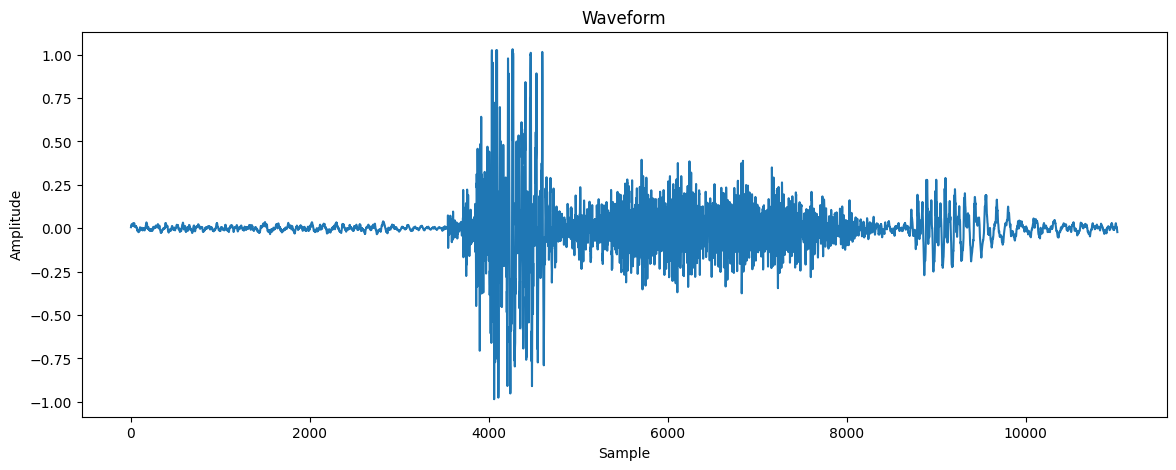

In [17]:
import matplotlib.pyplot as plt

# Assuming list_audio_train[0] contains your audio data and sr is the sample rate
plt.figure(figsize=(14, 5))
plt.plot(list_audio_train[0])
plt.title('Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

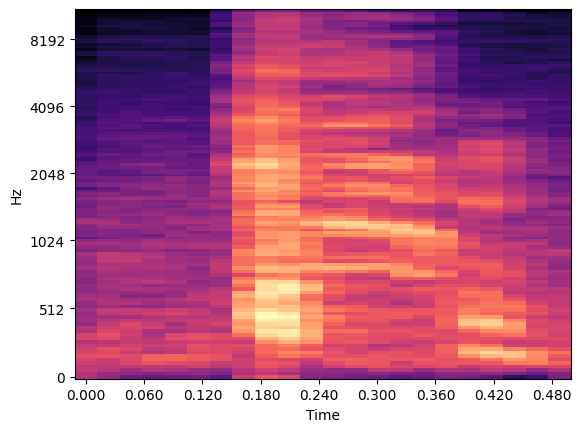

In [18]:
librosa.display.specshow(mel_spectrogram_train[0], y_axis='mel', x_axis='time', auto_aspect=True)
#plt.savefig()

In [19]:
print(y_train.head(50))

7633    0
4312    0
5572    0
7576    0
2239    0
1101    0
6552    0
2579    0
6168    1
1844    0
3176    0
76      0
6848    1
4363    1
7461    0
8660    1
6698    1
8370    0
8277    0
9394    0
9593    0
8006    0
8601    0
8637    1
2284    1
1909    0
1737    1
7624    0
8913    1
8341    0
2560    0
887     0
3745    0
5820    0
1174    1
853     0
5339    0
1483    1
4502    0
4137    0
2246    0
9031    1
1066    1
3323    0
9637    0
133     0
2703    1
530     0
5569    0
7012    0
Name: label, dtype: int64


#### Model development using tensorflow

In [20]:
input_shape = X_train.shape[1:]
print('Input shape:', input_shape)

# Instantiate the `tf.keras.layers.Normalization` layer.
#norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
#norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    #Downsample the input.
    layers.Resizing(128, 128),
    layers.Conv2D(16, 3, activation='relu'),
    layers.AveragePooling2D(),   
    layers.Conv2D(16, 3, activation='relu'),
    layers.AveragePooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.AveragePooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.AveragePooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.AveragePooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid'),
])

model.summary()


Input shape: (128, 22, 1)


2023-12-25 08:54:20.739721: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-25 08:54:20.739747: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-25 08:54:20.739780: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-25 08:54:20.739845: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-25 08:54:20.739882: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 128, 128, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 16)      160       
                                                                 
 average_pooling2d (Average  (None, 63, 63, 16)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 16)        2320      
                                                                 
 average_pooling2d_1 (Avera  (None, 30, 30, 16)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        4

In [21]:

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', 'AUC'],
)


In [22]:
EPOCHS = 200
try:
    history = model.fit(
        X_train, y_train,
        validation_data= (X_test, y_test),
        epochs=EPOCHS,
        callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_auc', verbose=1, patience=5, restore_best_weights=True),
    )
except KeyboardInterrupt:
    print("Training interrupted by user.")


Epoch 1/200


2023-12-25 08:54:22.451007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-12-25 08:54:22.569015: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


184/184 [==============================] - 16s 79ms/step - loss: 0.6147 - accuracy: 0.6961 - auc: 0.5481 - val_loss: 0.6041 - val_accuracy: 0.7003 - val_auc: 0.6171
Epoch 2/200
184/184 [==============================] - 13s 68ms/step - loss: 0.5974 - accuracy: 0.7039 - auc: 0.6069 - val_loss: 0.5906 - val_accuracy: 0.7013 - val_auc: 0.6342
Epoch 3/200
184/184 [==============================] - 6s 33ms/step - loss: 0.5899 - accuracy: 0.7029 - auc: 0.6306 - val_loss: 0.5925 - val_accuracy: 0.7008 - val_auc: 0.6317
Epoch 4/200
184/184 [==============================] - 10s 55ms/step - loss: 0.5873 - accuracy: 0.7015 - auc: 0.6416 - val_loss: 0.5835 - val_accuracy: 0.7013 - val_auc: 0.6593
Epoch 5/200
184/184 [==============================] - 9s 49ms/step - loss: 0.5755 - accuracy: 0.7061 - auc: 0.6649 - val_loss: 0.5766 - val_accuracy: 0.7049 - val_auc: 0.6663
Epoch 6/200
184/184 [==============================] - 10s 53ms/step - loss: 0.5781 - accuracy: 0.7034 - auc: 0.6690 - val_loss: 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.24934147
Epoch 3, change: 0.15172246
Epoch 4, change: 0.14712854
Epoch 5, change: 0.10517200
Epoch 6, change: 0.09013334
Epoch 7, change: 0.07680837
Epoch 8, change: 0.07190561
Epoch 9, change: 0.06468037
Epoch 10, change: 0.06157580
Epoch 11, change: 0.05649747
Epoch 12, change: 0.05242317
Epoch 13, change: 0.04847370
Epoch 14, change: 0.04565902
Epoch 15, change: 0.04329664
Epoch 16, change: 0.04063755
Epoch 17, change: 0.03871258
Epoch 18, change: 0.03665153
Epoch 19, change: 0.03564878
Epoch 20, change: 0.03346810
Epoch 21, change: 0.03222818
Epoch 22, change: 0.03060967
Epoch 23, change: 0.02915740
Epoch 24, change: 0.02816580
Epoch 25, change: 0.02693478
Epoch 26, change: 0.02612434
Epoch 27, change: 0.02542673
Epoch 28, change: 0.02461313
Epoch 29, change: 0.02397875
Epoch 30, change: 0.02325115
Epoch 31, change: 0.02285863
Epoch 32, change: 0.02208452
Epoch 33, change: 0.02153722
Epoch 34, change: 0.02097187
Epoch 35, change: 0.020

/Users/sudac/anaconda3/envs/hms-cxr/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


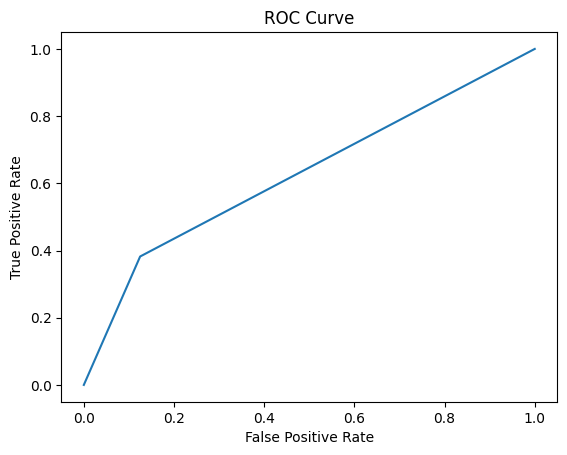

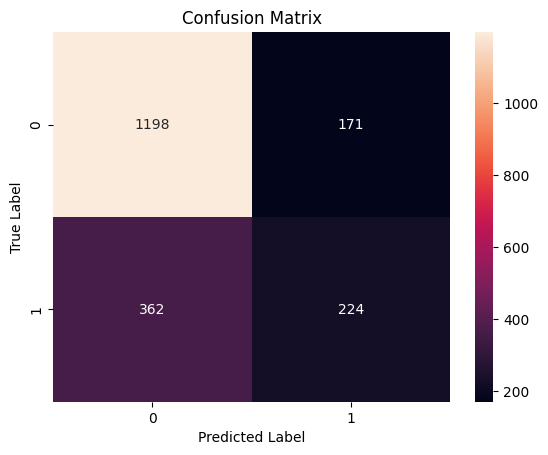

In [23]:
# test logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

# flatten the spectrograms
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# fit the model
logreg = LogisticRegression(n_jobs=-1, verbose=1, tol=.0001, random_state=42, solver='saga')
logreg.fit(X_train_flat, y_train)

# predict on test set
y_pred = logreg.predict(X_test_flat)

# evaluate performance
print(accuracy_score(y_test, y_pred))
print("AUC", roc_auc_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



#### Validating the performance of the model on individual audio

In [24]:
from sklearn.metrics import roc_auc_score
y_pred = model.predict(X_val)
roc_auc_score(y_val, y_pred)

62/62 [==============================] - 1s 16ms/step


0.745818613655869

#### Validating the performance of the model on individual patient

62/62 [==============================] - 1s 15ms/step
AUC: 0.7621638210021203


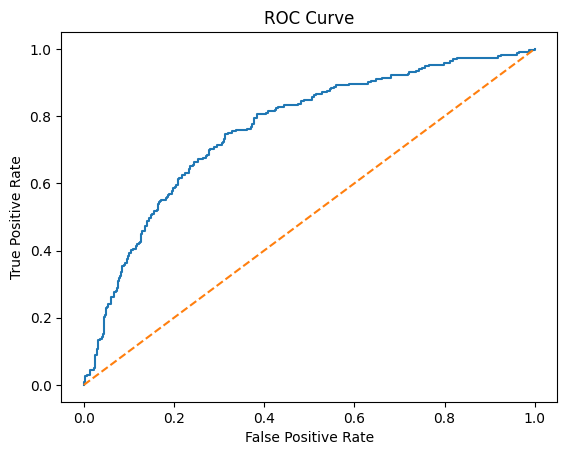

Threshold value is: 0.3620462
Sensitivity: 0.7456896551724138
Specificity: 0.6860841423948221
              precision    recall  f1-score   support

       No TB       0.88      0.69      0.77       618
          TB       0.47      0.74      0.58       232

    accuracy                           0.70       850
   macro avg       0.67      0.71      0.67       850
weighted avg       0.77      0.70      0.72       850



In [25]:
df_val['probability'] = model.predict(X_val)
df = df_val.groupby(['participant'], as_index=False)[['probability', 'label']].mean()
roc_auc_score(df['label'], df['probability'])

# print auc  and auc curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(df['label'], df['probability'])
print("AUC:", roc_auc_score(df['label'], df['probability']))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# the sensitivity and specificity for the threshold that maximizes the sum of sensitivity and specificity
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
print("Sensitivity:", tpr[optimal_idx])
print("Specificity:", 1 - fpr[optimal_idx])

# print confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = np.where(df['probability'] > optimal_threshold, 1, 0)
confusion_matrix(df['label'], y_pred)

# print classification report
from sklearn.metrics import classification_report
target_names = ['No TB', 'TB']
print(classification_report(df['label'], y_pred, target_names=target_names))